In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import math
from matplotlib import cm, colors
from matplotlib.patches import Circle
from matplotlib.colors import LinearSegmentedColormap

# Set font sizes for plots
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes Ttle
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the Tck labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the Tck labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure Ttle
plt.rc('font', size=MEDIUM_SIZE)

# Global warming levels
years = np.linspace(1850, 2100, 251)
Tglob = ["T0","T15","T27"]
Tglob_values = [0,1.5,2.7]

# Data path
data_path = '/work/uo1227/u241297/GWL-analyses/data/Permafrostarea_Steinert2024/'

# CMIP6 models from Steinert et al. (2024)
models = ["ACCESS-CM2","ACCESS-ESM1-5","BCC-CSM2-MR","CAMS-CSM1-0","CanESM5-1","CanESM5-CanOE","CanESM5","CESM2","CESM2-WACCM","CMCC-CM2-SR5","CMCC-ESM2","CNRM-CM6-1","CNRM-ESM2-1","E3SM-1-0","E3SM-1-1-ECA","E3SM-1-1","EC-Earth3","FGOALS-f3-L","GFDL-CM4","GFDL-ESM4","GISS-E2-1-G","GISS-E2-1-H","GISS-E2-2-G","HadGEM3-GC31-LL","IPSL-CM6A-LR","MIROC6","MIROC-ES2L","MRI-ESM2-0","NorESM2-LM","NorESM2-MM","TaiESM1","UKESM1-0-LL"]

# Permafrost area (active layer thickness)

In [2]:
# Read permafrost area (defined as acTve layer thickness < 3m (ALT))
pfa_alt = {
    model: np.squeeze(xr.open_dataset(data_path + "pfa_merged/" + model + "_pf_alt.nc")['pf_alt'])
    for model in models
}

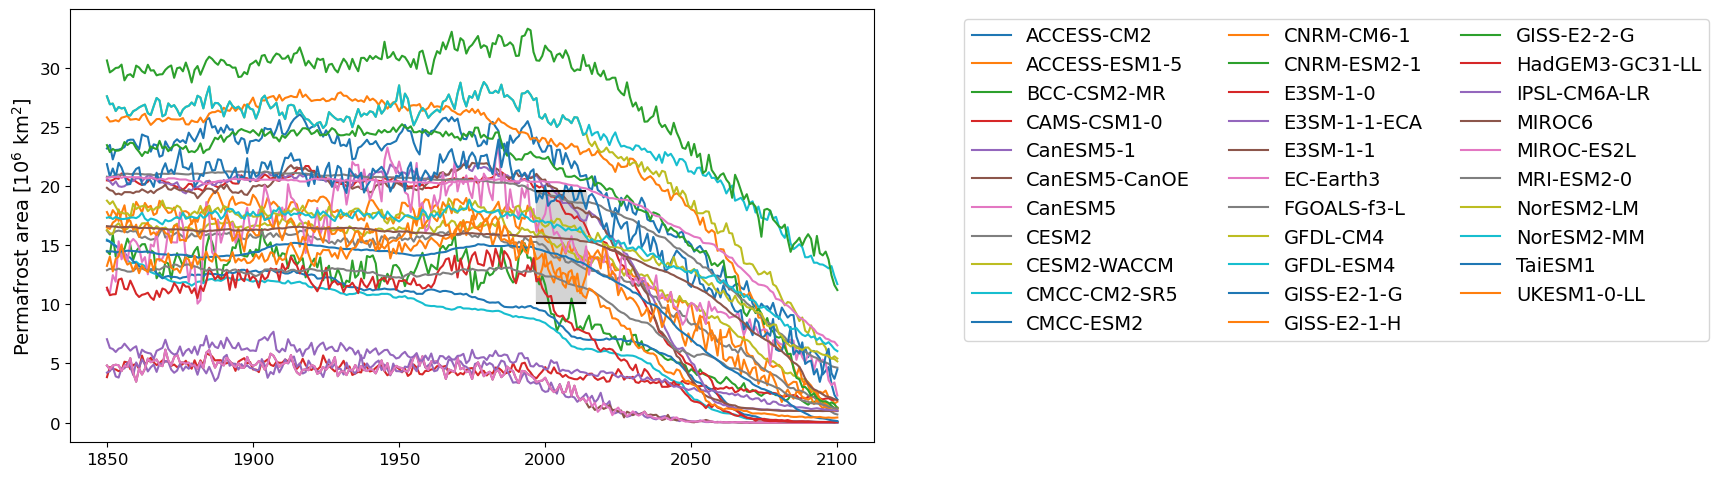

In [3]:
# Plot timeseries of permafrost area for all models
plt.figure(figsize=(18,5))
for model in models:
    try:
        plt.plot(years,pfa_alt[model],label=model)
    except:
        plt.plot(years[:-1],pfa_alt[model],label=model)
        
plt.legend(bbox_to_anchor=(1.1,1),ncol=3)
plt.ylabel(r'Permafrost area [$10^6$ km$^2$]')
plt.hlines(10.1,1997,2014,'k')
plt.hlines(19.6,1997,2014,'k')

# mark oberservational range
plt.fill_between([1997,2014],[10.1,10.1],[19.6,19.6],color='lightgray')

plt.tight_layout()
plt.show()

# Model selection

In [4]:
# Select models based on observed permafrost area: 13.9 (10.1–19.6) Mio. km2 for period 1997-2014 (Steinert et al., 2024)
models_selected_alt = [
    model for model in models 
    if 10.1 < np.mean(pfa_alt[model][147:165]) < 19.6
]

In [5]:
# remove models with missing ssp585 data on Levante (supercomputer)
models_selected_alt.remove("E3SM-1-0")
models_selected_alt.remove("E3SM-1-1-ECA")
models_selected_alt.remove("GISS-E2-1-H")

In [6]:
models_selected_alt

['ACCESS-ESM1-5',
 'CESM2',
 'CESM2-WACCM',
 'E3SM-1-1',
 'EC-Earth3',
 'FGOALS-f3-L',
 'GISS-E2-1-G',
 'MIROC6',
 'MRI-ESM2-0',
 'NorESM2-LM',
 'NorESM2-MM',
 'TaiESM1',
 'UKESM1-0-LL']

# Global warming levels

In [7]:
# Load global surface air temperature (gsat) for selected models
gsat = {}
gsata = {}
gsata_rm = {}
for model in models_selected_alt:
    file = "/work/uo1227/u241297/GWL-analyses/data/CMIP6_GSAT/"+model+"/gsat_r1i1p1f1.nc"
    gsat[model] = np.squeeze(xr.open_dataset(file)['tas'])
    gsata[model] = gsat[model] - np.mean(gsat[model][0:51])
    gsata_rm[model] = np.array(pd.DataFrame(gsata[model]).rolling(20, center=True).mean())

In [8]:
# Determine the indices of the GWL periods
gwl_ind = {model: {"T0": np.arange(10, 30)} for model in models_selected_alt}

for model in models_selected_alt:
    for T in range(1, 3):
        j = 20
        while gsata_rm[model][j] < Tglob_values[T]:
            j += 1
        gwl_ind[model][Tglob[T]] = np.arange(j-10, j+10)

In [10]:
# GWL samples of permafrost area
pfa_alt_gwl = {}
pfa_alt_gwl_mm = {}

for T in range(3):
    Tglob_key = Tglob[T]
    
    # Compute mean permafrost area for each model at the given GWL
    pfa_alt_gwl[Tglob_key] = {
        model: np.mean(pfa_alt[model][gwl_ind[model][Tglob_key]])
        for model in models_selected_alt
    }
    
    # Compute the multi-model mean for the given GWL
    pfa_alt_gwl_mm[Tglob_key] = np.mean(list(pfa_alt_gwl[Tglob_key].values()))

# Circle plots

In [11]:
# Constants
NH_landarea = 41.68 # land area north of 45°N
center = (0.5, 0.5)
radius_NHland = 0.5

# Load the colormap
cmap = LinearSegmentedColormap.from_list('', ['purple', 'lightgray'])

# Create subplots
fig, ax = plt.subplots(1,3,figsize=(15,5))

# Loop over the three GWLs
for T in range(3):
    # Draw outer circle
    circle_NHland = Circle(center, radius_NHland, fc=cmap(0.99))
    ax[T].add_patch(circle_NHland)

    # Draw permafrost area circles
    for perc in range(100, -1, -1):
        radius = radius_NHland * math.sqrt(np.percentile(list(pfa_alt_gwl[Tglob[T]].values()), perc) / NH_landarea)
        circle = Circle(center, radius, fc=cmap(perc / 100))
        ax[T].add_patch(circle)

    # Draw inner purple circle at minimum PFA
    circle = Circle(center, radius, fc='purple')
    ax[T].add_patch(circle)
    
    ax[T].set_aspect('equal')
    ax[T].axis('off')

# Add a colorbar
cax = fig.add_axes([0.94, 0.18, 0.015, 0.64])
norm = colors.Normalize(vmin=0, vmax=100)
sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Probability of permafrost cover [%]')

plt.show()